<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [1]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [2]:
!nvidia-smi

Tue Oct 13 12:25:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [4]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.1
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [5]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')

In [6]:
full_data = full_data[['ID', 'WF', 'U_100m', 'V_100m', 'U_10m', 'V_10m', 'T', 'CLCT', 'Set',
       'Wind Speed 100m', 'Wind Direction 100m', 'Wind Speed 10m',
       'Wind Direction 10m','Month_Number']]

In [7]:
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [8]:
X.head()

,ID,WF,U_100m,V_100m,U_10m,V_10m,T,CLCT,Set,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,Month_Number
Time,,,,,,,,,,,,,,
2018-05-01 01:00:00,12479,WF3,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,Train,6.936299,0.583268,1.687717,0.895782,5
2018-05-01 02:00:00,12480,WF3,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,Train,7.170127,0.578533,1.723264,1.036951,5
2018-05-01 03:00:00,12481,WF3,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,Train,6.000870,0.151837,1.707938,0.981212,5
2018-05-01 04:00:00,12482,WF3,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,Train,5.470862,0.312855,1.454695,0.786528,5
2018-05-01 05:00:00,12483,WF3,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,Train,4.896512,0.143904,1.280704,0.660129,5


## Scaling Data

For a better performance of the Network, here the data is scaled between [-1,1] using MinMaxScaler. For the Direction Data, presented in degrees, Sin and Cos are calculated, which naturally have values in this same scale.

In [9]:
def preprocessing_X(X):

  scaler = MinMaxScaler(feature_range=(-1,1))

  X_saved_columns = X[['ID','WF','Set','Month_Number']]
  X_saved_columns = X_saved_columns.reset_index().drop('Time',axis=1)
  X = X.drop(['ID','WF','Set','Month_Number'],axis=1)

  # Fill NaN's
  #X = X.fillna(method="ffill", axis=1) # ZOH
  #X = X.fillna(0)

  # Scaling Data
  directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
  directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
  directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
  directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
  directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))
  directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  directions = directions.reset_index().drop('Time',axis=1)

  X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  X_columns = X.columns

  X = scaler.fit_transform(X)
  X = pd.DataFrame(X,columns=X_columns)
  X = pd.concat([X,directions],axis=1)
  X = pd.concat([X,X_saved_columns],axis=1)

  X = X.fillna(-2)

  return X

In [10]:
def preprocessing_y(y):

  scaler = MinMaxScaler(feature_range=(-1,1))

  #y = y.fillna(method="ffill", axis=1) # ZOH
  #y = y.fillna(0)
  y = y.drop('ID',axis=1)
  y = scaler.fit_transform(y)
  y = pd.DataFrame(y)
  y = y.fillna(-2)

  return y,scaler

In [11]:
y.shape

(6239, 2)

## Subsets Creation

Here, the Data is converted to a group of subsets where each subset has n_steps of past data.

In [12]:
n_steps = 60

In [13]:
# split a multivariate sequence into samples
def split_sequences(X, y = None, n_steps = 1):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x = X[i:end_ix, :]
		sample_X.append(seq_x)
		if y is not None:
			seq_y = y[end_ix-1,-1]
			sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [14]:
def shift_save(df,n_steps):
  empty = pd.DataFrame(np.zeros((n_steps-1,df.shape[1])),columns=df.columns)
  df = pd.concat([empty,df])
  return df

In [15]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [16]:
n_features = sample_X.shape[2] - 2

## Model

Here, a function to create the Model usin Keras is defined.

In [17]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=128,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.4)(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=87,return_sequences=True,stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.4)(hidden_2)

  hidden_3 = tf.keras.layers.LSTM(units=57,stateful=True)(hidden_2)
  hidden_3 = tf.keras.layers.Dropout(0.4)(hidden_3)

  # Output
  #outputs = tf.keras.layers.PReLU()(hidden_2)
  #outputs = tf.keras.layers.Dropout(rate=0.2)(hidden_2)
  outputs = tf.keras.layers.Dense(units=1)(hidden_3)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [18]:
def LSTM_Model_2(input_shape, batch_size=1):

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(128, batch_input_shape=(batch_size, input_shape[0], input_shape[1]), return_sequences=True,stateful=True))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.LSTM(87, return_sequences=True,stateful=True))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.LSTM(57, stateful=True))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(1))

  return model

In [19]:
input_shape = (n_steps,n_features)

In [20]:
model = LSTM_Model(input_shape)

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 60, 12)]             0         
_________________________________________________________________
lstm (LSTM)                  (1, 60, 128)              72192     
_________________________________________________________________
dropout (Dropout)            (1, 60, 128)              0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 60, 87)               75168     
_________________________________________________________________
dropout_1 (Dropout)          (1, 60, 87)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 57)                   33060     
_________________________________________________________________
dropout_2 (Dropout)          (1, 57)                  

## Validation

In [22]:
random.seed(317)
tf.random.set_seed(317)

patience = 3
epochs = 10
k_fold_splits = 5
total_it = 50
monitor = "root_mean_squared_error"
batch_size = 1

### Hold Out Score

Here, the same model is trained on all the data used on the Validation and tested on a Holdout Set never seen before.

In [23]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [24]:
X_train = preprocessing_X(X_train)
X_val = preprocessing_X(X_val)
X_holdout = preprocessing_X(X_holdout)

X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
X_holdout = X_holdout.drop(['ID','WF','Set','Month_Number'],axis=1)

y_train,scaler = preprocessing_y(y_train)
y_val,_ = preprocessing_y(y_val)
y_holdout,_ = preprocessing_y(y_holdout)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [25]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [26]:
model = LSTM_Model_2(input_shape)

In [27]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4619/4619 [==============================] - 41s 9ms/step - loss: 0.0612 - root_mean_squared_error: 0.2473 - val_loss: 0.1093 - val_root_mean_squared_error: 0.3306
Epoch 2/10
4619/4619 [==============================] - 41s 9ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0845 - val_root_mean_squared_error: 0.2908
Epoch 3/10
4619/4619 [==============================] - 40s 9ms/step - loss: 0.0338 - root_mean_squared_error: 0.1840 - val_loss: 0.0846 - val_root_mean_squared_error: 0.2909
Epoch 4/10
4619/4619 [==============================] - 40s 9ms/step - loss: 0.0310 - root_mean_squared_error: 0.1760 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 5/10
4619/4619 [==============================] - 40s 9ms/step - loss: 0.0295 - root_mean_squared_error: 0.1719 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 6/10
4619/4619 [==============================] - 41s 9ms/step - loss: 0.0292 - root_mean_squared_error: 0.1709 - val_l

In [28]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

Here, Predicitions and True Labels of the Holdout Set are scaled back to measure the CAPE Error, and be compared on a Chart.

In [29]:
preds = scaler.inverse_transform(preds)
y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

In [30]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [31]:
metric_cnr(preds,y_holdout)

('CAPE', 26.228719000215953)

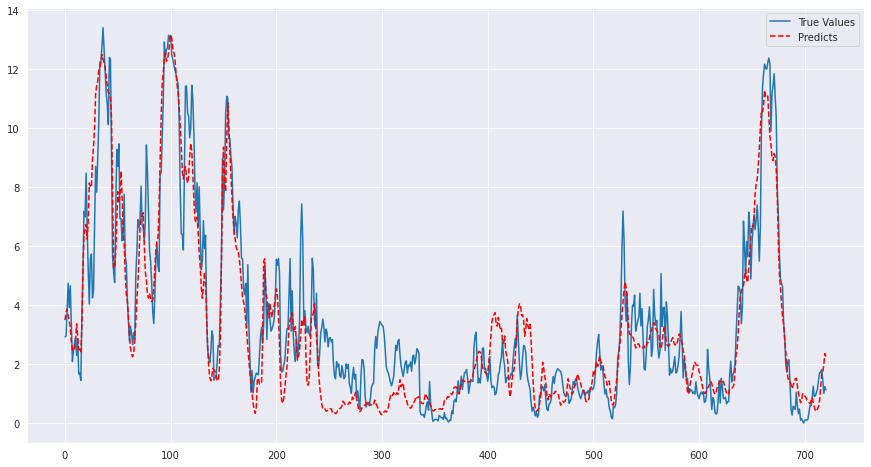

In [32]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Submission Generation

First, a function with all the preprocessing made to prepare data for network is defined.

Here's a Function with all the Process of Submit Gen for One Wind Farm. This Model is the Standard:

In [33]:
def WF_submit_gen(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test = full_X_test.reset_index().drop('index',axis=1)
  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Months Loop
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue
    
    # Separate Month Data on Numpy Matrix
    ids = X_test.index
    X_test = full_X_test_split[[ids]]

    # Append Data Already Predicted
    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model Creation and Training
    model = LSTM_Model_2(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [34]:
def WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Months Loop
  WF_preds = pd.DataFrame(columns=['Production'])
  predicted_X_test = pd.DataFrame(columns=full_X_train.columns)
  predicted_X_test.index.names = ['Time']
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test_pure = pd.concat([X_test,X_test_10])
    else:
      X_test_pure = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue

    # Append Data Already Predicted
    X_train = pd.concat([full_X_train,predicted_X_test])
    y_train = pd.concat([full_y_train,WF_preds])

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Preprocessing Data
    X_train = preprocessing_X(X_train)
    X_val = preprocessing_X(X_val)
    X_test = preprocessing_X(X_test_pure)

    # Shift-Save on X_test
    X_test = shift_save(X_test,n_steps)

    X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_test = X_test.drop(['ID','WF','Set','Month_Number'],axis=1)

    y_train,scaler_y = preprocessing_y(y_train)
    y_val,_ = preprocessing_y(y_val)

    # Subset Creation 

    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, _ = split_sequences(X_test.values,None,n_steps)

    # Model Creation and Training
    model = LSTM_Model_2(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])
    pred = pd.DataFrame(pred,columns=['Production'])

    # Save Predictions on Final Array
    predicted_X_test = pd.concat([predicted_X_test,X_test_pure])

    pred = scaler_y.inverse_transform(pred)
    pred = pd.DataFrame(pred,columns=['Production'])
    WF_preds = pd.concat([WF_preds,pred])

  #WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  #WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

Direct Submit Generation:

In [35]:
def WF_submit_gen_3(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Split Train Data on Train and Validation Set
  X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, test_size=0.3, shuffle=False)

  # Model Creation and Training
  model = LSTM_Model(input_shape,batch_size=batch_size)
  callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

  # Prediction Generation
  pred = model.predict(full_X_test_split,batch_size = batch_size,callbacks=callbacks_list)
  pred = pred.reshape(pred.shape[0])

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(pred))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [1]:
final_preds = pd.DataFrame()
for WF in full_data['WF'].unique():
  WF_preds = WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size)
  final_preds = final_preds.append(WF_preds)

NameError: ignored

In [ ]:
final_preds = final_preds.reset_index().drop('index',axis=1)
final_preds['ID'] = pd.read_csv(r'random_submission_example.csv')['ID']
final_preds = final_preds.set_index('ID')

In [ ]:
final_preds

In [ ]:
plt.plot(final_preds.index,final_preds['Production'])

In [ ]:
final_preds.to_csv('Submission_LSTM.csv')

In [ ]:
from google.colab import files
files.download('Submission_LSTM.csv')